### Lisa Over, Homework 3

## Part I
#### LightGBM
AUC Train: 0.7046<BR>
AUC Test: 0.6744<BR>
Accuracy: 0.742 with threshold 0.37
#### XGBoost
AUC Train: 0.6567<BR>
AUC Test: 0.6567
#### CatBoost - Best Model with Test AUC=0.6825 and Accuracy=0.796
Even though AUC on test is a little higher than that of LightGBM, the difference between train and test AUC is slightly lower.<BR>
AUC Train: 0.7148<BR>
AUC Test: 0.6825<BR>
Accuracy: 0.796 with threshold 0.52
    
## Part II
#### SHAP with LightGBM model
<STRONG>Force plot for row 5</STRONG><BR>
This plot shows that number_inpatient and discharge_disposition_id_1 contribute to bringing the score down. The value of number_inpatient is -0.5033, which is a low value for the scaled continuous variable. The value of discharge_disposition_id_1 is 0.8304, which is a high value for the scaled dummy variable.<BR>
<STRONG>Summary plots</STRONG><BR>
The force plot for row 5 is consistent with the summary plots for both the train and test sets, which show that low values of number_inpatient reduce the score by 0.0 to 0.2 points while high values of number_inpatient increase the score by 0.05 to 0.6 points. High values of discharge_disposition_id_1 reduce the score by 0.0 to ~0.05 points while low scores increase the score by 0.0 to ~0.1 points. <BR>
<STRONG>Interaction with dependence contribution plots</STRONG><BR>
There is a positive linear relationship between number_inpatient and the SHAP value for number_inpatient. As number_inpatient increases, the SHAP value, and thus the score, increase.  There is an interaction between number_inpatient and discharge_disposition_id_1. When number_inpatient is greater than 1, discharge_disposition_id_1 tends to be higher for higher SHAP values of number_inpatient. Perhaps if someone's disposition at discharge is 1 for discharge_disposition_id_1, doctor's should attempt to mitigate this disposition even if it means a longer stay. In the end, a longer stay in one visit may result in a shorter length of stay than the combined length of stays of more than one hospital admittance.

## Part III
#### LightGBM with Hyperband
<STRONG>Best parameters from Hyperband: AUC train 0.8148, AUC val 0.6924 - OVERFIT</STRONG><BR>
 'scale_pos_weight': 0.28,<BR>
 'reg_lambda': 1.8000000000000007,<BR>
 'reg_alpha': 0.45000000000000007,<BR>
 'objective': 'binary',<BR>
 'num_leaves': 225,<BR>
 'n_jobs': -1,<BR>
 'n_estimators': 200,<BR>
 'min_child_samples': 50,<BR>
 'max_depth': 116,<BR>
 'learning_rate': 0.03,<BR>
 'boosting_type': 'gbdt'<BR>
<BR>
<STRONG>Improved fit: AUC train 0.7046, AUC val 0.6744 - the following parameters were changed:</STRONG><BR>
reg_lambda to 2<BR>
reg_alpha to 0.5<BR>
n_estimators to 300<BR>
learning_rate to 0.001

In [1]:
import warnings;
warnings.filterwarnings('ignore');

In [2]:
# Import libraries
import csv
import pandas as pd

from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib

from numpy.random import seed
from numpy.random import randn
import numpy as np
from numpy import exp
from numpy import sqrt
from numpy import argmax
from numpy import arange
import os
import math
import seaborn as sns
from sklearn import metrics

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, f1_score
from sklearn.model_selection import cross_val_score

import imblearn as imb
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost, CatBoostClassifier, Pool, cv

import hyperopt as hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import colorama
N_HYPEROPT_PROBES = 60
HYPEROPT_ALGO = tpe.suggest
colorama.init()

import hyperband
from hyperband import HyperbandSearchCV
import sklearn
sklearn.metrics.SCORERS.keys()

import shap

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1) It is an inpatient encounter (a hospital admission).
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3) The length of stay was at least 1 day and at most 14 days.
(4) Laboratory tests were performed during the encounter.
(5) Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.

### Data Preprocessing

In [33]:
# Read in csv file for Python lab - train/validation set
pd.set_option('display.max_columns', None)
diab_data = pd.read_csv('diabetic_data.csv')

# Display the head
diab_data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [34]:
diab_df = diab_data.copy()

In [35]:
diab_df.describe(include = 'all')

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,1.017660e+05,1.017660e+05,101766,101766,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766,101766,101766,101766.000000,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,NaN,NaN,6,3,10,10,NaN,NaN,NaN,NaN,18,73,NaN,NaN,NaN,NaN,NaN,NaN,717,749,790,NaN,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,NaN,NaN,Caucasian,Female,[70-80),?,NaN,NaN,NaN,NaN,?,?,NaN,NaN,NaN,NaN,NaN,NaN,428,276,250,NaN,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,NaN,NaN,76099,54708,26068,98569,NaN,NaN,NaN,NaN,40256,49949,NaN,NaN,NaN,NaN,NaN,NaN,6862,6752,11555,NaN,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864
mean,1.652016e+08,5.433040e+07,NaN,NaN,NaN,NaN,2.024006,3.715642,5.754437,4.395987,NaN,NaN,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,NaN,NaN,NaN,7.422607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1.026403e+08,3.869636e+07,NaN,NaN,NaN,NaN,1.445403,5.280166,4.064081,2.985108,NaN,NaN,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,NaN,NaN,NaN,1.933600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.252200e+04,1.350000e+02,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,8.496119e+07,2.341322e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,2.000000,NaN,NaN,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.523890e+08,4.550514e+07,NaN,NaN,NaN,NaN,1.000000,1.000000,7.000000,4.000000,NaN,NaN,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.302709e+08,8.754595e+07,NaN,NaN,NaN,NaN,3.000000,4.000000,7.000000,6.000000,NaN,NaN,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,NaN,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill categorical '?' with 'Unknown' or 'U'

In [36]:
diab_df.replace(to_replace ="?", 
                 value ="Unknown", inplace=True) 

In [37]:
diab_df.race.unique()

array(['Caucasian', 'AfricanAmerican', 'Unknown', 'Other', 'Asian',
       'Hispanic'], dtype=object)

In [38]:
diab_df.gender.unique()

array(['Female', 'Male', 'Unknown/Invalid'], dtype=object)

In [39]:
diab_df.age.unique()

array(['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)',
       '[60-70)', '[70-80)', '[80-90)', '[90-100)'], dtype=object)

In [40]:
diab_df.weight.unique()

array(['Unknown', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [41]:
diab_df.admission_type_id.unique()

array([6, 1, 2, 3, 4, 5, 8, 7])

In [42]:
diab_df.discharge_disposition_id.unique()

array([25,  1,  3,  6,  2,  5, 11,  7, 10,  4, 14, 18,  8, 13, 12, 16, 17,
       22, 23,  9, 20, 15, 24, 28, 19, 27])

In [43]:
diab_df.admission_source_id.unique()

array([ 1,  7,  2,  4,  5,  6, 20,  3, 17,  8,  9, 14, 10, 22, 11, 25, 13])

In [44]:
diab_df.shape

(101766, 50)

### Replace '/' with '_' in gender column and '<', '>' from A1Cresult column

In [45]:
#diab_df['gender'] = diab_df['gender'].apply(lambda x: x.replace('/', '_'))

In [46]:
#diab_df['A1Cresult'] = diab_df['A1Cresult'].apply(lambda x: x.replace('>', 'grt'))
#diab_df['A1Cresult'] = diab_df['A1Cresult'].apply(lambda x: x.replace('<', 'less'))

### Change variable names if they have a hyphen; change hyphen to underscore

In [47]:
diab_df['glyburide_metformin'] = diab_df['glyburide-metformin']
diab_df['glipizide_metformin'] = diab_df['glipizide-metformin']
diab_df['glimepiride_pioglitazone'] = diab_df['glimepiride-pioglitazone']
diab_df['metformin_rosiglitazone'] = diab_df['metformin-rosiglitazone']
diab_df['metformin_pioglitazone'] = diab_df['metformin-pioglitazone']

In [48]:
diab_df.drop(['glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone'], inplace = True, axis=1)

### Fill NaN with constant -999

In [49]:
# Replace numeric variable NaN values with -999
diab_df.fillna(-999, inplace=True)

In [50]:
diab_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,change,diabetesMed,readmitted,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,Unknown,Unknown,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,No,No,No,No,No
1,149190,55629189,Caucasian,Female,[10-20),Unknown,1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,>30,No,No,No,No,No
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,No,No,No,No,No
3,500364,82442376,Caucasian,Male,[30-40),Unknown,1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,NO,No,No,No,No,No
4,16680,42519267,Caucasian,Male,[40-50),Unknown,1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,Ch,Yes,NO,No,No,No,No,No


### Create binary variable for LOS and check (0, 1) proportions

In [97]:
diab_df['readmit_less30'] = np.where(diab_df['readmitted']=='<30',1,0)
diab_df['readmit_less30'].head()

0    0
1    0
2    0
3    0
4    0
Name: readmit_less30, dtype: int64

In [98]:
freq = pd.crosstab(diab_df['readmit_less30'], columns='count')
freq

col_0,count
readmit_less30,
0,90409
1,11357


In [99]:
# Obtain distribution of abnormLOS
labels = diab_df['readmit_less30'].astype('category').cat.categories.tolist()
freq = pd.crosstab(diab_df['readmit_less30'], columns='proportion').apply(lambda r: r/len(diab_df), axis=1)
freq.head(len(labels))

col_0,proportion
readmit_less30,
0,0.888401
1,0.111599


## Create copies of diab_df for different algorithms

In [178]:
diab_dummy = diab_df.copy()

In [179]:
diab_cat = diab_df.copy()

### Label encode 'age' and 'weight' - diab_dummy

In [180]:
def age_to_numeric(x):
    if x=='[0-10)':
        return 1
    if x=='[10-20)':
        return 2
    if x=='[20-30)':
        return 3
    if x=='[30-40)':
        return 4
    if x=='[40-50)':
        return 5
    if x=='[50-60)':
        return 6
    if x=='[60-70)':
        return 7
    if x=='[70-80)':
        return 8
    if x=='[80-90)':
        return 9
    if x=='[90-100)':
        return 10
    
def weight_to_numeric(x):
    if x=='[0-25)':
        return 1
    if x=='[25-50)':
        return 2
    if x=='[50-75)':
        return 3
    if x=='[75-100)':
        return 4
    if x=='[100-125)':
        return 5
    if x=='[125-150)':
        return 6
    if x=='[150-175)':
        return 7
    if x=='[175-200)':
        return 8
    if x=='>200':
        return 9
    if x=='Unknown':
        return -999

In [181]:
diab_dummy.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,change,diabetesMed,readmitted,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmit_less30
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,Unknown,Unknown,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),Unknown,1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,>30,No,No,No,No,No,0
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,No,No,No,No,No,0
3,500364,82442376,Caucasian,Male,[30-40),Unknown,1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,NO,No,No,No,No,No,0
4,16680,42519267,Caucasian,Male,[40-50),Unknown,1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,Ch,Yes,NO,No,No,No,No,No,0


In [182]:
diab_dummy['age_num'] = diab_dummy['age'].apply(age_to_numeric)

In [183]:
diab_dummy['weight_num'] = diab_dummy['weight'].apply(weight_to_numeric)

In [184]:
diab_dummy.drop(['age', 'weight'], inplace=True, axis=1)

In [185]:
diab_dummy.head()

,encounter_id,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,change,diabetesMed,readmitted,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmit_less30,age_num,weight_num
0,2278392,8222157,Caucasian,Female,6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,Unknown,Unknown,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,No,No,No,No,No,0,1,-999
1,149190,55629189,Caucasian,Female,1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,>30,No,No,No,No,No,0,2,-999
2,64410,86047875,AfricanAmerican,Female,1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,No,No,No,No,No,0,3,-999
3,500364,82442376,Caucasian,Male,1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,NO,No,No,No,No,No,0,4,-999
4,16680,42519267,Caucasian,Male,1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,Ch,Yes,NO,No,No,No,No,No,0,5,-999


### Convert variables to dummies - diab_dummy

In [186]:
# Create dummy variables of string variables 
diab_dummy = pd.get_dummies(diab_dummy, columns=['race'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['gender'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['admission_type_id'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['discharge_disposition_id'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['admission_source_id'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['payer_code'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['medical_specialty'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['diag_1'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['diag_2'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['diag_3'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['max_glu_serum'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['A1Cresult'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['metformin'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['repaglinide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['nateglinide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['chlorpropamide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['glimepiride'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['acetohexamide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['glipizide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['glyburide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['tolbutamide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['pioglitazone'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['rosiglitazone'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['acarbose'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['miglitol'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['troglitazone'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['tolazamide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['examide'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['citoglipton'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['insulin'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['glyburide_metformin'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['glipizide_metformin'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['glimepiride_pioglitazone'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['metformin_rosiglitazone'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['metformin_pioglitazone'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['change'])
diab_dummy = pd.get_dummies(diab_dummy, columns=['diabetesMed'])

In [187]:
diab_dummy.shape

(101766, 2504)

In [188]:
diab_dummy.head()

encounter_id  patient_nbr  time_in_hospital  num_lab_procedures  \
0       2278392      8222157                 1                  41   
1        149190     55629189                 3                  59   
2         64410     86047875                 2                  11   
3        500364     82442376                 2                  44   
4         16680     42519267                 1                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  number_diagnoses readmitted  readmit_less30  age_num  \
0                 0                 1         NO               0        1   
1                 0                 9        >30               0        2   
2                 1                 6         NO               0        3   
3                 0                 7         NO               0        4   
4                 0                 5         NO               0        5   

   weight_num  race_AfricanAmerican  race_Asian  race_Caucasian  \
0        -999                     0           0               1   
1        -999                     0           0               1   
2        -999                     1           0               0   
3        -999                     0           0               1   
4        -999                     0           0               1   

   race_Hispanic  race_Other  race_Unknown  gender_Female  gender_Male  \
0              0           0             0              1            0   
1              0           0             0              1            0   
2              0           0             0              1            0   
3              0           0             0              0            1   
4              0           0             0              0            1   

   gender_Unknown/Invalid  admission_type_id_1  admission_type_id_2  \
0                       0                    0                    0   
1                       0                    1                    0   
2                       0                    1                    0   
3                       0                    1                    0   
4                       0                    1                    0   

   admission_type_id_3  admission_type_id_4  admission_type_id_5  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   admission_type_id_6  admission_type_id_7  admission_type_id_8  \
0                    1                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   discharge_disposition_id_1  discharge_disposition_id_2  \
0                           0                           0   
1                           1                           0   
2                           1                           0   
3                           1                           0   
4                           1                           0   

   discharge_disposition_id_3  discharge_disposition_id_4  \
0                           0                           0   
1                           0                           0   
2                        

### Scale numeric variables - diab_dummy

In [189]:
# Get numeric columns, to be scaled, into a list
cols = list(diab_dummy.columns)
noscale_cols = ['readmitted', 'readmit_less30', 'encounter_id', 'patient_nbr', 'age_num', 'weight_num']

num_cols = list(set(cols) - set(noscale_cols))

In [190]:
diab_dummy[num_cols] = preprocessing.scale(diab_dummy[num_cols])

In [191]:
diab_dummy.head()

encounter_id  patient_nbr  time_in_hospital  num_lab_procedures  \
0       2278392      8222157         -1.137649           -0.106517   
1        149190     55629189         -0.467653            0.808384   
2         64410     86047875         -0.802651           -1.631351   
3        500364     82442376         -0.802651            0.045967   
4         16680     42519267         -1.137649            0.401761   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0       -0.785398        -1.848268          -0.291461          -0.21262   
1       -0.785398         0.243390          -0.291461          -0.21262   
2        2.145781        -0.371804           1.286748          -0.21262   
3       -0.199162        -0.002688          -0.291461          -0.21262   
4       -0.785398        -0.986997          -0.291461          -0.21262   

   number_inpatient  number_diagnoses readmitted  readmit_less30  age_num  \
0         -0.503276         -3.321596         NO               0        1   
1         -0.503276          0.815784        >30               0        2   
2          0.288579         -0.735733         NO               0        3   
3         -0.503276         -0.218561         NO               0        4   
4         -0.503276         -1.252906         NO               0        5   

   weight_num  race_AfricanAmerican  race_Asian  race_Caucasian  \
0        -999             -0.482380   -0.079616        0.580762   
1        -999             -0.482380   -0.079616        0.580762   
2        -999              2.073054   -0.079616       -1.721876   
3        -999             -0.482380   -0.079616        0.580762   
4        -999             -0.482380   -0.079616        0.580762   

   race_Hispanic  race_Other  race_Unknown  gender_Female  gender_Male  \
0      -0.142917    -0.12256     -0.151148       0.927452    -0.927397   
1      -0.142917    -0.12256     -0.151148       0.927452    -0.927397   
2      -0.142917    -0.12256     -0.151148       0.927452    -0.927397   
3      -0.142917    -0.12256     -0.151148      -1.078223     1.078287   
4      -0.142917    -0.12256     -0.151148      -1.078223     1.078287   

   gender_Unknown/Invalid  admission_type_id_1  admission_type_id_2  \
0                -0.00543            -1.063045            -0.471048   
1                -0.00543             0.940694            -0.471048   
2                -0.00543             0.940694            -0.471048   
3                -0.00543             0.940694            -0.471048   
4                -0.00543             0.940694            -0.471048   

   admission_type_id_3  admission_type_id_4  admission_type_id_5  \
0            -0.477095            -0.009913            -0.222125   
1            -0.477095            -0.009913            -0.222125   
2            -0.477095            -0.009913            -0.222125   
3            -0.477095            -0.009913            -0.222125   
4            -0.477095            -0.009913            -0.222125   

   admission_type_id_6  admission_type_id_7  admission_type_id_8  \
0             4.270105            -0.014367            -0.056164   
1            -0.234186            -0.014367            -0.056164   
2            -0.234186            -0.014367            -0.056164   
3            -0.234186            -0.014367            -0.056164   
4            -0.234186            -0.014367            -0.056164   

   discharge_disposition_id_1  discharge_disposition_id_2  \
0                   -1.204285                   -0.146141   
1                    0.830368                   -0.146141   
2                    0.830368                   -0.146141   
3                    0.830368                   -0.146141   
4                    0.830368                   -0.146141   

   discharge_disposition_id_3  discharge_disposition_id_4  \
0                   -0.398632                   -0.089851   
1                   -0.398632                   -0.089851   
2                   -0.39

### Scale numeric variables - diab_cat

In [192]:
#list(diab_cat.columns)

In [193]:
# Get numeric columns, to be scaled, into a list
nbr_cols = diab_cat.columns[diab_cat.columns.str.startswith('num')]

In [194]:
nbr_cols

Index(['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

In [195]:
diab_cat[nbr_cols] = preprocessing.scale(diab_cat[nbr_cols])

In [196]:
diab_cat.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,change,diabetesMed,readmitted,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmit_less30
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,6,25,1,1,Unknown,Pediatrics-Endocrinology,-0.106517,-0.785398,-1.848268,-0.291461,-0.21262,-0.503276,250.83,Unknown,Unknown,-3.321596,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),Unknown,1,1,7,3,Unknown,Unknown,0.808384,-0.785398,0.243390,-0.291461,-0.21262,-0.503276,276,250.01,255,0.815784,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,>30,No,No,No,No,No,0
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2,Unknown,Unknown,-1.631351,2.145781,-0.371804,1.286748,-0.21262,0.288579,648,250,V27,-0.735733,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,No,No,No,No,No,0
3,500364,82442376,Caucasian,Male,[30-40),Unknown,1,1,7,2,Unknown,Unknown,0.045967,-0.199162,-0.002688,-0.291461,-0.21262,-0.503276,8,250.43,403,-0.218561,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,NO,No,No,No,No,No,0
4,16680,42519267,Caucasian,Male,[40-50),Unknown,1,1,7,1,Unknown,Unknown,0.401761,-0.785398,-0.986997,-0.291461,-0.21262,-0.503276,197,157,250,-1.252906,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,Ch,Yes,NO,No,No,No,No,No,0


### Create x variables and target; split into train and validate sets - diab_dummy

In [197]:
target_dummy = diab_dummy['readmit_less30']
target_dummy.head()

0    0
1    0
2    0
3    0
4    0
Name: readmit_less30, dtype: int64

In [198]:
diab_dummy.head()

encounter_id  patient_nbr  time_in_hospital  num_lab_procedures  \
0       2278392      8222157         -1.137649           -0.106517   
1        149190     55629189         -0.467653            0.808384   
2         64410     86047875         -0.802651           -1.631351   
3        500364     82442376         -0.802651            0.045967   
4         16680     42519267         -1.137649            0.401761   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0       -0.785398        -1.848268          -0.291461          -0.21262   
1       -0.785398         0.243390          -0.291461          -0.21262   
2        2.145781        -0.371804           1.286748          -0.21262   
3       -0.199162        -0.002688          -0.291461          -0.21262   
4       -0.785398        -0.986997          -0.291461          -0.21262   

   number_inpatient  number_diagnoses readmitted  readmit_less30  age_num  \
0         -0.503276         -3.321596         NO               0        1   
1         -0.503276          0.815784        >30               0        2   
2          0.288579         -0.735733         NO               0        3   
3         -0.503276         -0.218561         NO               0        4   
4         -0.503276         -1.252906         NO               0        5   

   weight_num  race_AfricanAmerican  race_Asian  race_Caucasian  \
0        -999             -0.482380   -0.079616        0.580762   
1        -999             -0.482380   -0.079616        0.580762   
2        -999              2.073054   -0.079616       -1.721876   
3        -999             -0.482380   -0.079616        0.580762   
4        -999             -0.482380   -0.079616        0.580762   

   race_Hispanic  race_Other  race_Unknown  gender_Female  gender_Male  \
0      -0.142917    -0.12256     -0.151148       0.927452    -0.927397   
1      -0.142917    -0.12256     -0.151148       0.927452    -0.927397   
2      -0.142917    -0.12256     -0.151148       0.927452    -0.927397   
3      -0.142917    -0.12256     -0.151148      -1.078223     1.078287   
4      -0.142917    -0.12256     -0.151148      -1.078223     1.078287   

   gender_Unknown/Invalid  admission_type_id_1  admission_type_id_2  \
0                -0.00543            -1.063045            -0.471048   
1                -0.00543             0.940694            -0.471048   
2                -0.00543             0.940694            -0.471048   
3                -0.00543             0.940694            -0.471048   
4                -0.00543             0.940694            -0.471048   

   admission_type_id_3  admission_type_id_4  admission_type_id_5  \
0            -0.477095            -0.009913            -0.222125   
1            -0.477095            -0.009913            -0.222125   
2            -0.477095            -0.009913            -0.222125   
3            -0.477095            -0.009913            -0.222125   
4            -0.477095            -0.009913            -0.222125   

   admission_type_id_6  admission_type_id_7  admission_type_id_8  \
0             4.270105            -0.014367            -0.056164   
1            -0.234186            -0.014367            -0.056164   
2            -0.234186            -0.014367            -0.056164   
3            -0.234186            -0.014367            -0.056164   
4            -0.234186            -0.014367            -0.056164   

   discharge_disposition_id_1  discharge_disposition_id_2  \
0                   -1.204285                   -0.146141   
1                    0.830368                   -0.146141   
2                    0.830368                   -0.146141   
3                    0.830368                   -0.146141   
4                    0.830368                   -0.146141   

   discharge_disposition_id_3  discharge_disposition_id_4  \
0                   -0.398632                   -0.089851   
1                   -0.398632                   -0.089851   
2                   -0.39

In [199]:
# Get columns to drop from x
drp_cols = ['encounter_id', 'patient_nbr', 'readmit_less30', 'readmitted']

In [200]:
diab_dummy['encounter_id'].head()

0    2278392
1     149190
2      64410
3     500364
4      16680
Name: encounter_id, dtype: int64

In [201]:
diab_dummy.drop(drp_cols, inplace=True, axis=1)

In [202]:
x_train, x_val, y_train, y_val = train_test_split(diab_dummy, 
                                                    target_dummy, 
                                                    test_size=0.2, 
                                                    random_state=1)

#### Create new train set by oversampling

In [203]:
# check imblearn version number
print(imb.__version__)

0.5.0


In [204]:
# define oversampling strategy
oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.75, random_state=10)

In [205]:
# fit and apply the transform
x_over, y_over = oversample.fit_resample(x_train, y_train)

In [206]:
print(Counter(y_over))

Counter({0: 72244, 1: 54183})


In [207]:
x_over_df = pd.DataFrame(x_over, columns = x_train.columns)
y_over_df = pd.DataFrame(y_over, columns = ['readmit_less30'])

#### Write to CSV file

In [208]:
y_val = pd.DataFrame(y_val, columns = ['readmit_less30'])
y_val.head()

,readmit_less30
60753,0
84068,0
58710,1
24001,1
20797,0


In [209]:
x_over_df.to_csv(r'x_train_dummy.csv')
x_val.to_csv(r'x_val_dummy.csv')
y_over_df.to_csv(r'y_train_dummy.csv')
y_val.to_csv(r'y_val_dummy.csv')

### Create x variables and target; split into train and validate sets - diab_cat

In [211]:
target_cat = diab_cat['readmit_less30']
target_cat.head()

0    0
1    0
2    0
3    0
4    0
Name: readmit_less30, dtype: int64

In [212]:
diab_cat.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,change,diabetesMed,readmitted,glyburide_metformin,glipizide_metformin,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,readmit_less30
0,2278392,8222157,Caucasian,Female,[0-10),Unknown,6,25,1,1,Unknown,Pediatrics-Endocrinology,-0.106517,-0.785398,-1.848268,-0.291461,-0.21262,-0.503276,250.83,Unknown,Unknown,-3.321596,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO,No,No,No,No,No,0
1,149190,55629189,Caucasian,Female,[10-20),Unknown,1,1,7,3,Unknown,Unknown,0.808384,-0.785398,0.243390,-0.291461,-0.21262,-0.503276,276,250.01,255,0.815784,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,>30,No,No,No,No,No,0
2,64410,86047875,AfricanAmerican,Female,[20-30),Unknown,1,1,7,2,Unknown,Unknown,-1.631351,2.145781,-0.371804,1.286748,-0.21262,0.288579,648,250,V27,-0.735733,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO,No,No,No,No,No,0
3,500364,82442376,Caucasian,Male,[30-40),Unknown,1,1,7,2,Unknown,Unknown,0.045967,-0.199162,-0.002688,-0.291461,-0.21262,-0.503276,8,250.43,403,-0.218561,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,Ch,Yes,NO,No,No,No,No,No,0
4,16680,42519267,Caucasian,Male,[40-50),Unknown,1,1,7,1,Unknown,Unknown,0.401761,-0.785398,-0.986997,-0.291461,-0.21262,-0.503276,197,157,250,-1.252906,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,Ch,Yes,NO,No,No,No,No,No,0


In [213]:
# Get columns to drop from x
drp_cols = ['encounter_id', 'patient_nbr', 'readmit_less30', 'readmitted']

In [214]:
diab_cat['encounter_id'].head()

0    2278392
1     149190
2      64410
3     500364
4      16680
Name: encounter_id, dtype: int64

In [215]:
diab_cat.drop(drp_cols, inplace=True, axis=1)

In [216]:
x_train, x_val, y_train, y_val = train_test_split(diab_cat, 
                                                    target_cat, 
                                                    test_size=0.2, 
                                                    random_state=1)

#### Create new train set by oversampling

In [217]:
# define oversampling strategy
oversample = imb.over_sampling.RandomOverSampler(sampling_strategy=0.75, random_state=10)

In [218]:
# fit and apply the transform
x_over, y_over = oversample.fit_resample(x_train, y_train)

In [219]:
print(Counter(y_over))

Counter({0: 72244, 1: 54183})


In [220]:
x_over_df = pd.DataFrame(x_over, columns = x_train.columns)
y_over_df = pd.DataFrame(y_over, columns = ['readmit_less30'])

#### Write to CSV file

In [221]:
# COnvert to Pandas data frame so it is in the same format as the other files
y_val = pd.DataFrame(y_val, columns = ['readmit_less30'])
y_val.head()

,readmit_less30
60753,0
84068,0
58710,1
24001,1
20797,0


In [222]:
x_over_df.to_csv(r'x_train_cat.csv')
x_val.to_csv(r'x_val_cat.csv')
y_over_df.to_csv(r'y_train_cat.csv')
y_val.to_csv(r'y_val_cat.csv')

# Read Train and Validate files - with dummy variables
This section must be run before both the LightGBM abd XGBoost models can be run.

In [3]:
# Read in csv files for Python lab - train/validation/test sets
pd.set_option('display.max_columns', None)
x_train = pd.read_csv('x_train_dummy.csv')
x_val = pd.read_csv('x_val_dummy.csv')
y_train = pd.read_csv('y_train_dummy.csv')
y_val = pd.read_csv('y_val_dummy.csv')

In [4]:
x_train.drop(['Unnamed: 0'], inplace=True, axis=1)
x_val.drop(['Unnamed: 0'], inplace=True, axis=1)
y_train.drop(['Unnamed: 0'], inplace=True, axis=1)
y_val.drop(['Unnamed: 0'], inplace=True, axis=1)

# LightGBM with Hyperband

In [5]:
y_val[y_val['readmit_less30']==1].shape[0] / y_val[y_val['readmit_less30']==0].shape[0]

0.12050646848334709

In [8]:
hb_lgb_model = lgb.LGBMClassifier()

lgb_hb_param_dict = {'boosting_type' : ['gbdt'],
                    'num_leaves' : np.arange(2, 251),
                    'max_depth' : np.arange(2, 251),
                    'learning_rate' : [0.001, 0.005, 0.01, 0.02, 0.03],
                    'n_estimators' : np.arange(50, 501),
                    #subsample_for_bin : [],
                    'objective' : ['binary'],
                    #'class_weight' : [],
                    #'min_split_gain' : [],
                    #'min_child_weight' : [],
                    'min_child_samples' : [20, 30, 40, 50],
                    #'subsample' : [],
                    #'subsample_freq' : [],
                    #'colsample_bytree' : [],
                    'scale_pos_weight' : [0.28],
                    'reg_alpha' : np.arange(0.1, 2, 0.05),
                    'reg_lambda' : np.arange(0.1, 2, 0.05),
                    'n_jobs' : [-1]
                    }

In [9]:
search = HyperbandSearchCV(hb_lgb_model, lgb_hb_param_dict, cv=3,
                           verbose = 1,
                           max_iter=200,min_iter=50,
                           scoring='f1_macro')

#### The following is commented out so I wouldn't accidentally re-run it - it takes forever
The best parameters from Hyperband are copied below.

In [10]:
#search.fit(x_train_dummy,y_train)

In [11]:
#search.best_params_

{
 'scale_pos_weight': 0.28,
 'reg_lambda': 1.8000000000000007,
 'reg_alpha': 0.45000000000000007,
 'objective': 'binary',
 'num_leaves': 225,
 'n_jobs': -1,
 'n_estimators': 200,
 'min_child_samples': 50,
 'max_depth': 116,
 'learning_rate': 0.03,
 'boosting_type': 'gbdt'
}

In [12]:
# AUC train 0.8148; AUC val 0.6924 - OVERFIT
lgb_params = {
 'scale_pos_weight': 0.28,
 'reg_lambda': 1.8000000000000007,
 'reg_alpha': 0.45000000000000007,
 'objective': 'binary',
 'num_leaves': 225,
 'n_jobs': -1,
 'n_estimators': 200,
 'min_child_samples': 50,
 'max_depth': 116,
 'learning_rate': 0.03,
 'boosting_type': 'gbdt'
}

In [13]:
# AUC train 0.6614; AUC val 0.6601
lgb_params = {
 'scale_pos_weight': 0.28,
 'reg_lambda': 2,
 'reg_alpha': 0.5,
 'objective': 'binary',
 'num_leaves': 225,
 'n_jobs': -1,
 'n_estimators': 200,
 'min_child_samples': 50,
 'max_depth': 116,
 'learning_rate': 0.001,
 'boosting_type': 'gbdt'
}

In [14]:
# AUC train 0.9134; AUC val 0.6846 - OVERFIT
lgb_params = {
 #'scale_pos_weight': 0.28,
 'reg_lambda': 1.8000000000000007,
 'reg_alpha': 0.45000000000000007,
 'objective': 'binary',
 'num_leaves': 225,
 'n_jobs': -1,
 'n_estimators': 300,
 'min_child_samples': 50,
 'max_depth': 90,
 'learning_rate': 0.03,
 'boosting_type': 'gbdt'
}

In [15]:
# AUC train 0.6682; AUC val 0.6674
lgb_params = {
 'scale_pos_weight': 0.28,
 'reg_lambda': 2,
 'reg_alpha': 0.5,
 'objective': 'binary',
 'num_leaves': 225,
 'n_jobs': -1,
 'n_estimators': 300,
 'min_child_samples': 50,
 'max_depth': 116,
 'learning_rate': 0.001,
 'boosting_type': 'gbdt'
}

#### Best fit

In [6]:
# AUC train 0.7046; AUC val 0.6744
lgb_params = {
 'scale_pos_weight': 0.28,
 'reg_lambda': 2,
 'reg_alpha': 0.5,
 'objective': 'binary',
 'num_leaves': 225,
 'n_jobs': -1,
 'n_estimators': 300,
 'min_child_samples': 50,
 'max_depth': 116,
 'learning_rate': 0.001,
 'boosting_type': 'gbdt'
}

In [7]:
lgb_mort_train = lgb.Dataset(x_train, y_train)
lgb_val_train = lgb.Dataset(x_val, y_val)

In [8]:
lgb_gbm = lgb.train(params = lgb_params, train_set = lgb_mort_train,
                num_boost_round = 100, valid_sets = [lgb_val_train, lgb_mort_train],
               valid_names = ['Evaluation', 'Train'])

[1]	Train's binary_logloss: 0.682817	Evaluation's binary_logloss: 0.59019
[2]	Train's binary_logloss: 0.682726	Evaluation's binary_logloss: 0.589825
[3]	Train's binary_logloss: 0.682635	Evaluation's binary_logloss: 0.589461
[4]	Train's binary_logloss: 0.682544	Evaluation's binary_logloss: 0.589098
[5]	Train's binary_logloss: 0.682454	Evaluation's binary_logloss: 0.588735
[6]	Train's binary_logloss: 0.682364	Evaluation's binary_logloss: 0.588372
[7]	Train's binary_logloss: 0.682275	Evaluation's binary_logloss: 0.58801
[8]	Train's binary_logloss: 0.682186	Evaluation's binary_logloss: 0.587649
[9]	Train's binary_logloss: 0.682097	Evaluation's binary_logloss: 0.587289
[10]	Train's binary_logloss: 0.682009	Evaluation's binary_logloss: 0.586929
[11]	Train's binary_logloss: 0.681921	Evaluation's binary_logloss: 0.586569
[12]	Train's binary_logloss: 0.681833	Evaluation's binary_logloss: 0.586209
[13]	Train's binary_logloss: 0.681745	Evaluation's binary_logloss: 0.585851
[14]	Train's binary_log

[109]	Train's binary_logloss: 0.67477	Evaluation's binary_logloss: 0.554009
[110]	Train's binary_logloss: 0.674711	Evaluation's binary_logloss: 0.553703
[111]	Train's binary_logloss: 0.674651	Evaluation's binary_logloss: 0.553398
[112]	Train's binary_logloss: 0.674594	Evaluation's binary_logloss: 0.553093
[113]	Train's binary_logloss: 0.674535	Evaluation's binary_logloss: 0.552789
[114]	Train's binary_logloss: 0.674476	Evaluation's binary_logloss: 0.552485
[115]	Train's binary_logloss: 0.674419	Evaluation's binary_logloss: 0.552181
[116]	Train's binary_logloss: 0.674361	Evaluation's binary_logloss: 0.551878
[117]	Train's binary_logloss: 0.674304	Evaluation's binary_logloss: 0.551575
[118]	Train's binary_logloss: 0.674246	Evaluation's binary_logloss: 0.551273
[119]	Train's binary_logloss: 0.67419	Evaluation's binary_logloss: 0.550971
[120]	Train's binary_logloss: 0.674133	Evaluation's binary_logloss: 0.55067
[121]	Train's binary_logloss: 0.674076	Evaluation's binary_logloss: 0.550369
[1

[215]	Train's binary_logloss: 0.669848	Evaluation's binary_logloss: 0.52413
[216]	Train's binary_logloss: 0.669812	Evaluation's binary_logloss: 0.523871
[217]	Train's binary_logloss: 0.669776	Evaluation's binary_logloss: 0.523612
[218]	Train's binary_logloss: 0.669742	Evaluation's binary_logloss: 0.523354
[219]	Train's binary_logloss: 0.669707	Evaluation's binary_logloss: 0.523097
[220]	Train's binary_logloss: 0.669672	Evaluation's binary_logloss: 0.522839
[221]	Train's binary_logloss: 0.669636	Evaluation's binary_logloss: 0.522582
[222]	Train's binary_logloss: 0.669603	Evaluation's binary_logloss: 0.522325
[223]	Train's binary_logloss: 0.669568	Evaluation's binary_logloss: 0.522069
[224]	Train's binary_logloss: 0.669533	Evaluation's binary_logloss: 0.521812
[225]	Train's binary_logloss: 0.6695	Evaluation's binary_logloss: 0.521557
[226]	Train's binary_logloss: 0.669466	Evaluation's binary_logloss: 0.521302
[227]	Train's binary_logloss: 0.669432	Evaluation's binary_logloss: 0.521047
[2

In [9]:
lgb_train_probs = lgb_gbm.predict(x_train)
lgb_val_probs = lgb_gbm.predict(x_val)
lgb_train_probs

array([0.34680439, 0.37930516, 0.34351797, ..., 0.42780761, 0.36105587,
       0.33645516])

In [10]:
lgb_preds_train = pd.DataFrame(lgb_train_probs, columns = ['Prob1'])
lgb_preds_val = pd.DataFrame(lgb_val_probs, columns = ['Prob1'])
lgb_preds_val.head()

,Prob1
0,0.336455
1,0.363069
2,0.367318
3,0.346343
4,0.347247


In [11]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, lgb_train_probs)
train_auc = metrics.auc(fpr, tpr)
train_auc

0.7045973218096856

In [12]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, lgb_val_probs)
val_auc = metrics.auc(fpr, tpr)
val_auc

0.6743721485087274

In [13]:
train_auc - val_auc

0.030225173300958197

In [14]:
# Calculate the G-Mean for each threshold
# If G-Mean is optimized, it reflects the best balance between sensitivity and specificity
gmeans = sqrt(tpr * (1-fpr))

In [15]:
# Locate the index of the largest G-Mean to find the best threshold
ix = argmax(gmeans)
print('Best Threshold:%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold:0.358547, G-Mean=0.626


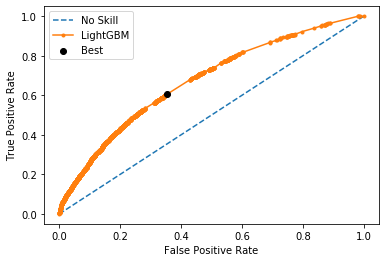

In [16]:
# Plot the ROC curve with the best sensitivity/specificity pair marked
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill', zorder=1)
pyplot.plot(fpr, tpr, marker='.', label='LightGBM', zorder=2)
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best', zorder=3)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [17]:
# Calculate Youden's J statistic for all thresholds
J = tpr-fpr
# Locate the index of the largest J to find the best threshold
ix = argmax(J)
print('Best Threshold=%f, J-Stat=%.3f' % (thresholds[ix], J[ix]))

Best Threshold=0.361967, J-Stat=0.254


In [18]:
# Calculate PR curve
precision, recall, thresholds = precision_recall_curve(y_val, lgb_val_probs)

In [19]:
# Calculate F-score
fscore = (2*precision*recall)/(precision+recall)
# Locate the index of the largest F to find the best threshold
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.368831, F-Score=0.280


In [20]:
# Get rid of the NaN in the fscore array (when precision and recall are both 0)
fscore = np.nan_to_num(fscore, nan=-9999)

In [21]:
# Locate the index of the largest F to find the best threshold
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.368831, F-Score=0.280


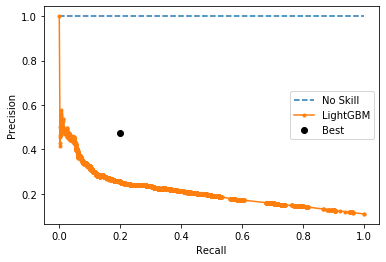

In [22]:
# Plot the PR ROC curve for the model with best precision/recall pair
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill', zorder=1)
pyplot.plot(recall, precision, marker='.', label='LightGBM', zorder=2)
pyplot.scatter(precision[ix], recall[ix], marker='o', color='black', label='Best', zorder=3)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [23]:
lgb_preds_train['Predicted Class'] = lgb_preds_train['Prob1'].apply(lambda x: 1 if x >= 0.37 else 0)
lgb_preds_train.head()

,Prob1,Predicted Class
0,0.346804,0
1,0.379305,1
2,0.343518,0
3,0.336455,0
4,0.406313,1


In [24]:
# Confusion matrix with 0.37 as threshold
con_matx = pd.crosstab(y_train['readmit_less30'], lgb_preds_train['Predicted Class'],
            rownames=['True'], colnames=['Predicted'], margins=True)
con_matx

Predicted,0,1,All
True,,,
0,56805,15439,72244
1,26856,27327,54183
All,83661,42766,126427


In [25]:
# Accuracy at threshold 0.37 is 
accuracy = (con_matx[0][0]+con_matx[1][1])/len(y_train)
accuracy

0.6654591187009105

In [26]:
lgb_preds_val['Predicted Class'] = lgb_preds_val['Prob1'].apply(lambda x: 1 if x >= 0.37 else 0)
lgb_preds_val.head()

,Prob1,Predicted Class
0,0.336455,0
1,0.363069,0
2,0.367318,0
3,0.346343,0
4,0.347247,0


In [27]:
# Confusion matrix with 0.37 as threshold
con_matx = pd.crosstab(y_val['readmit_less30'], lgb_preds_val['Predicted Class'],
            rownames=['True'], colnames=['Predicted'], margins=True)
con_matx

Predicted,0,1,All
True,,,
0,14103,4062,18165
1,1180,1009,2189
All,15283,5071,20354


In [28]:
# Accuracy at threshold 0.52 is 
accuracy = (con_matx[0][0]+con_matx[1][1])/len(y_val)
accuracy

0.7424584848187089

### SHAP for model explainability
https://github.com/slundberg/shap/blob/master/notebooks/plots/decision_plot.ipynb<BR>
https://www.kaggle.com/dansbecker/shap-values<BR>
https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

In [29]:
lgb_shap_explainer = shap.TreeExplainer(lgb_gbm)

In [30]:
expected_value = lgb_shap_explainer.expected_value
expected_value

array([-0.53848649])

In [31]:
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [-0.53848649]


In [32]:
row_to_show = 5
data_for_pred = x_val.iloc[row_to_show]
data_for_pred

time_in_hospital                -1.137649
num_lab_procedures              -1.580524
num_procedures                   0.387074
num_medications                 -1.110036
number_outpatient               -0.291461
                                   ...   
metformin_pioglitazone_Steady   -0.003135
change_Ch                       -0.926591
change_No                        0.926591
diabetesMed_No                   1.829868
diabetesMed_Yes                 -1.829868
Name: 5, Length: 2500, dtype: float64

In [33]:
data_for_pred_arry = data_for_pred.values.reshape(1, -1)
data_for_pred_arry

array([[-1.13764856, -1.5805236 ,  0.38707362, ...,  0.92659052,
         1.82986799, -1.82986799]])

In [34]:
lgb_gbm.predict(data_for_pred_arry)

array([0.33985345])

In [35]:
lgb_shap_values = lgb_shap_explainer.shap_values(data_for_pred_arry)

In [36]:
shap.initjs()
shap.force_plot(lgb_shap_explainer.expected_value[1], lgb_shap_values[1], data_for_pred)

In [16]:
lgb_shap_vals_train = lgb_shap_explainer.shap_values(x_train)

In [37]:
lgb_shap_vals_val = lgb_shap_explainer.shap_values(x_val)

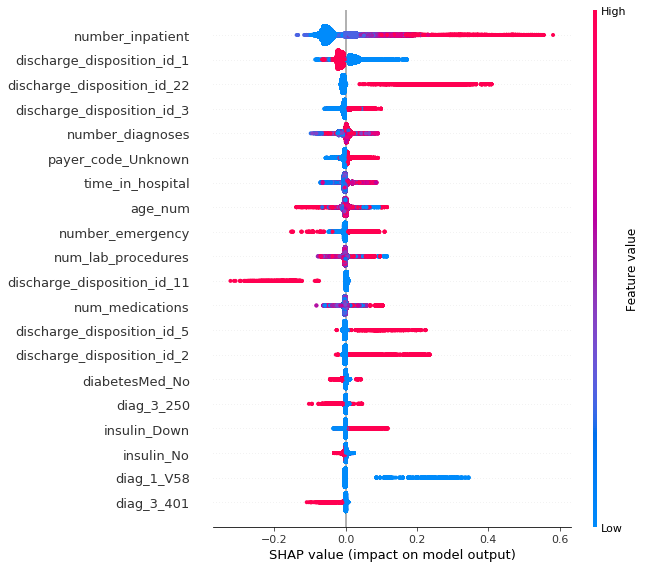

In [26]:
shap.summary_plot(lgb_shap_vals_train[1], x_train)

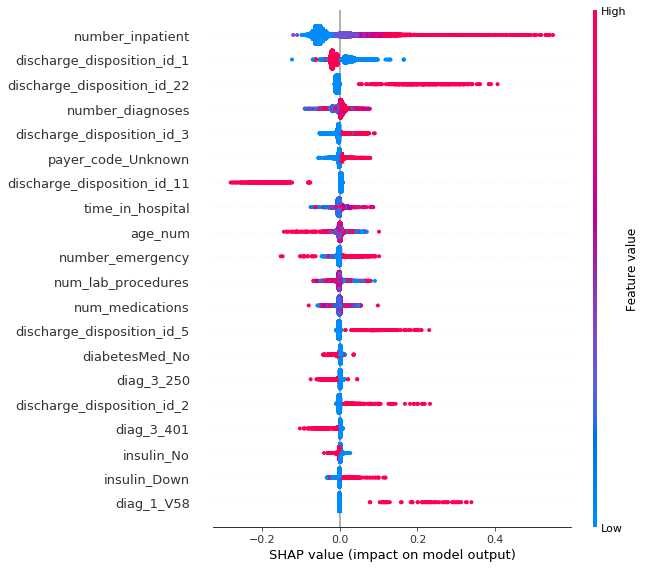

In [27]:
shap.summary_plot(lgb_shap_vals_val[1], x_val)

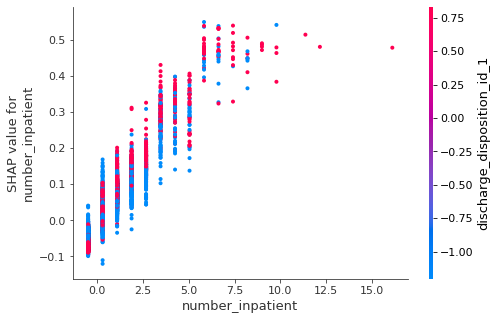

In [38]:
shap.initjs()
shap.dependence_plot("number_inpatient", lgb_shap_vals_val[1], x_val, interaction_index="discharge_disposition_id_1")

In [ ]:
lgb_var_interactions = shap.TreeExplainer(lgb_gbm).shap_interaction_values(x_val)

In [ ]:
shap.dependence_plot(("number_inpatient", "discharge_disposition_id_1"),
                     lgb_var_interactions, x_val,
                     display_features = x_val)

# XGBoost

In [86]:
dtrain = xgb.DMatrix(data = x_train, label = y_train)
dval = xgb.DMatrix(data = x_val, label = y_val)

The following parameters were the same as those used to run the XGBoost model for the lab. I tried them here, and they worked out well.

In [238]:
# AUC train 0.6517; val 0.6557 - very slightly UNDERFIT but within 0.03
param = {'booster': 'dart',
 'colsample_bytree': 0.75,
 'eval_metric': 'auc',
 'learning_rate': 0.014549851545016926,
 'max_depth': 16,
 'maximize': True,
 'min_child_weight': 900.0,
 'n_thread': 2,
 'reg_alpha': 805.3947036959058,
 'reg_lambda': 121.76259941293166,
 'scale_pos_weight': 9.268925857926515,
 'subsample': 0.9500000000000001,
 'verbose': True}

In [6]:
# specify validations set to watch performance
watchlist = [(dtrain, 'train'), (dval, 'eval')]
num_round = 100 
bst_auc = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds = 10)

In [7]:
xgb_train_probs = bst_auc.predict(dtrain)
xgb_val_probs = bst_auc.predict(dval)

In [241]:
xgb_prob_cols = ['Prob1']

In [242]:
xgb_preds_train = pd.DataFrame(xgb_train_probs, columns = xgb_prob_cols)
xgb_preds_val = pd.DataFrame(xgb_val_probs, columns = xgb_prob_cols)
xgb_preds_train.head()

,Prob1
0,0.758924
1,0.818948
2,0.735932
3,0.758924
4,0.818948


In [243]:
best_preds_trn = np.asarray([np.argmax(line) for line in xgb_train_probs])
best_preds_val = np.asarray([np.argmax(line) for line in xgb_val_probs])

In [244]:
best_preds_df_train = pd.DataFrame(best_preds_trn).add_prefix('PROB')

best_preds_df_val = pd.DataFrame(best_preds_val).add_prefix('PROB')
best_preds_df_val.head()

,PROB0
0,0
1,0
2,0
3,0
4,0


In [245]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, xgb_train_probs)
train_auc = metrics.auc(fpr, tpr)
train_auc

0.6566811386338781

In [246]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, xgb_val_probs)
train_auc = metrics.auc(fpr, tpr)
val_auc

0.6567209844986008

In [266]:
train_auc - val_auc

-0.017651164010126563

# Read Train and Validate files - with cat variables

In [4]:
# Read in csv files for Python lab - train/validation/test sets
pd.set_option('display.max_columns', None)
x_train = pd.read_csv('x_train_cat.csv')
x_val = pd.read_csv('x_val_cat.csv')
y_train = pd.read_csv('y_train_cat.csv')
y_val = pd.read_csv('y_val_cat.csv')

In [5]:
x_train.drop(['Unnamed: 0'], inplace=True, axis=1)
x_val.drop(['Unnamed: 0'], inplace=True, axis=1)
y_train.drop(['Unnamed: 0'], inplace=True, axis=1)
y_val.drop(['Unnamed: 0'], inplace=True, axis=1)

# CatBoost

In [6]:
is_cat = (x_train.dtypes != float)
cat_features_index = np.where(is_cat)[0]
cat_features_index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 16, 17, 18, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46])

In [7]:
train_pool = Pool(x_train, y_train, cat_features=cat_features_index)
val_pool = Pool(x_val, y_val, cat_features=cat_features_index)

In [ ]:
# AUC train 0.7231; val 0.6754 - OVERFIT
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=225,
                                    depth=6,
                                    l2_leaf_reg=10,
                                    learning_rate=0.01
                                    )

In [301]:
# AUC train 0.6397; val 0.6454
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=225,
                                    depth=1,
                                    l2_leaf_reg=10,
                                    learning_rate=0.001
                                    )

In [ ]:
# AUC train 0.7148; val 0.6825
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=225,
                                    depth=1,
                                    l2_leaf_reg=10,
                                    learning_rate=0.01
                                    )

In [311]:
# AUC train 0.6699; val 0.6728
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=225,
                                    depth=3,
                                    l2_leaf_reg=10,
                                    learning_rate=0.01
                                    )

In [ ]:
# AUC train 0.7148; val 0.6825
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=200,
                                    depth=1,
                                    l2_leaf_reg=10,
                                    learning_rate=0.01
                                    )

In [ ]:
# AUC train 0.7148; val 0.6825
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=100,
                                    depth=1,
                                    l2_leaf_reg=10,
                                    learning_rate=0.01
                                    )

#### Best Fit

In [43]:
# AUC train 0.7148; val 0.6825
model = CatBoostClassifier(iterations=20000,
                                    loss_function='Logloss',
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    early_stopping_rounds=500,
                                    od_type="Iter",
                                    verbose=2000,
                                    border_count=225,
                                    depth=1,
                                    l2_leaf_reg=10,
                                    learning_rate=0.01
                                    )

In [44]:
model.fit(train_pool, eval_set=val_pool, verbose=2000)

0:	test: 0.5778928	best: 0.5778928 (0)	total: 96.4ms	remaining: 32m 7s
2000:	test: 0.6813071	best: 0.6813071 (2000)	total: 3m 10s	remaining: 28m 35s
4000:	test: 0.6824951	best: 0.6824996 (3998)	total: 10m 25s	remaining: 41m 39s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.6825242244
bestIteration = 4237

Shrink model to first 4238 iterations.


In [45]:
pred = model.predict_proba(val_pool)
print("auc = ", sklearn.metrics.roc_auc_score(val_pool.get_label(), pred[:,1]))
print("acc = ", sklearn.metrics.accuracy_score(val_pool.get_label(), np.argmax(pred, axis=1)))
print("loss = ", sklearn.metrics.log_loss(val_pool.get_label(), pred, labels=[0, 1]))

auc =  0.6825242243547645
acc =  0.7733123710327209
loss =  0.5402615682032506


In [46]:
pred

array([[0.67649006, 0.32350994],
       [0.58932954, 0.41067046],
       [0.48077228, 0.51922772],
       ...,
       [0.55306954, 0.44693046],
       [0.83475264, 0.16524736],
       [0.66404073, 0.33595927]])

In [47]:
cb_train_probs = model.predict_proba(train_pool)
cb_val_probs = model.predict_proba(val_pool)

In [48]:
cb_prob_cols = ['Prob0', 'Prob1']

In [49]:
cb_preds_train = pd.DataFrame(cb_train_probs, columns = cb_prob_cols)
cb_preds_val = pd.DataFrame(cb_val_probs, columns = cb_prob_cols)
cb_preds_train.head()

,Prob0,Prob1
0,0.739024,0.260976
1,0.470949,0.529051
2,0.661421,0.338579
3,0.707551,0.292449
4,0.401322,0.598678


In [50]:
cb_train_prob1 = cb_train_probs[:,1]
cb_val_prob1 = cb_val_probs[:,1]

In [51]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, cb_train_prob1)
auc_trn = metrics.auc(fpr, tpr)
auc_trn

0.7147625582528727

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_val, cb_val_prob1)
auc_val = metrics.auc(fpr, tpr)
auc_val

0.6825242243547645

In [53]:
auc_trn - auc_val

0.03223833389810826

In [54]:
# Calculate the G-Mean for each threshold
# If G-Mean is optimized, it reflects the best balance between sensitivity and specificity
gmeans = sqrt(tpr * (1-fpr))

In [55]:
# Locate the index of the largest G-Mean to find the best threshold
ix = argmax(gmeans)
print('Best Threshold:%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold:0.408835, G-Mean=0.635


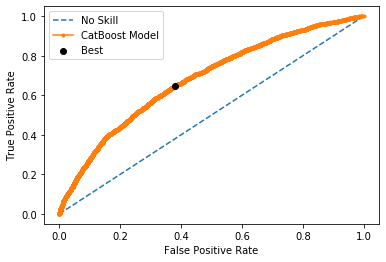

In [56]:
# Plot the ROC curve with the best sensitivity/specificity pair marked
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill', zorder=1)
pyplot.plot(fpr, tpr, marker='.', label='CatBoost', zorder=2)
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best', zorder=3)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

In [57]:
# Calculate Youden's J statistic for all thresholds
J = tpr-fpr
# Locate the index of the largest J to find the best threshold
ix = argmax(J)
print('Best Threshold=%f, J-Stat=%.3f' % (thresholds[ix], J[ix]))

Best Threshold=0.408835, J-Stat=0.270


In [58]:
# Calculate PR curve
precision, recall, thresholds = precision_recall_curve(y_val, cb_val_prob1)

In [59]:
# Calculate F-score
fscore = (2*precision*recall)/(precision+recall)
# Locate the index of the largest F to find the best threshold
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.519939, F-Score=0.292


In [60]:
# Get rid of the NaN in the fscore array (when precision and recall are both 0)
fscore = np.nan_to_num(fscore, nan=-9999)

In [61]:
# Locate the index of the largest F to find the best threshold
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.519939, F-Score=0.292


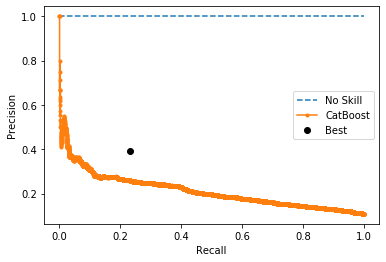

In [62]:
# Plot the PR ROC curve for the model with best precision/recall pair
no_skill = len(y_val[y_val==1]) / len(y_val)
pyplot.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill', zorder=1)
pyplot.plot(recall, precision, marker='.', label='CatBoost', zorder=2)
pyplot.scatter(precision[ix], recall[ix], marker='o', color='black', label='Best', zorder=3)
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

In [63]:
cb_preds_train['Predicted Class'] = cb_preds_train['Prob1'].apply(lambda x: 1 if x >= 0.52 else 0)
cb_preds_train.head()

,Prob0,Prob1,Predicted Class
0,0.739024,0.260976,0
1,0.470949,0.529051,1
2,0.661421,0.338579,0
3,0.707551,0.292449,0
4,0.401322,0.598678,1


In [64]:
# Confusion matrix with 0.52 as threshold
con_matx = pd.crosstab(y_train['readmit_less30'], cb_preds_train['Predicted Class'],
            rownames=['True'], colnames=['Predicted'], margins=True)
con_matx

Predicted,0,1,All
True,,,
0,61430,10814,72244
1,32629,21554,54183
All,94059,32368,126427


In [65]:
# Accuracy at threshold 0.52 is 
accuracy = (con_matx[0][0]+con_matx[1][1])/len(y_train)
accuracy

0.6563787798492411

In [66]:
cb_preds_val['Predicted Class'] = cb_preds_val['Prob1'].apply(lambda x: 1 if x >= 0.52 else 0)
cb_preds_val.head()

,Prob0,Prob1,Predicted Class
0,0.676490,0.323510,0
1,0.589330,0.410670,0
2,0.480772,0.519228,0
3,0.633347,0.366653,0
4,0.644316,0.355684,0


In [67]:
# Confusion matrix with 0.52 as threshold
con_matx = pd.crosstab(y_val['readmit_less30'], cb_preds_val['Predicted Class'],
            rownames=['True'], colnames=['Predicted'], margins=True)
con_matx

Predicted,0,1,All
True,,,
0,15357,2808,18165
1,1335,854,2189
All,16692,3662,20354


In [68]:
# Accuracy at threshold 0.52 is 
accuracy = (con_matx[0][0]+con_matx[1][1])/len(y_val)
accuracy

0.7964527856932299

SHAP error with CatBoost - list index out of range <BR>
Internet reference to the same:<BR>
https://github.com/slundberg/shap/issues/745